Using device: cuda
Frequency: 0.1 GHz, corresponding wavenumber k: 2.10


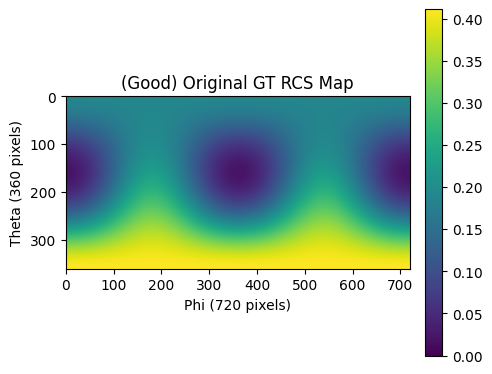


--- Helmholtz Residual Validation ---


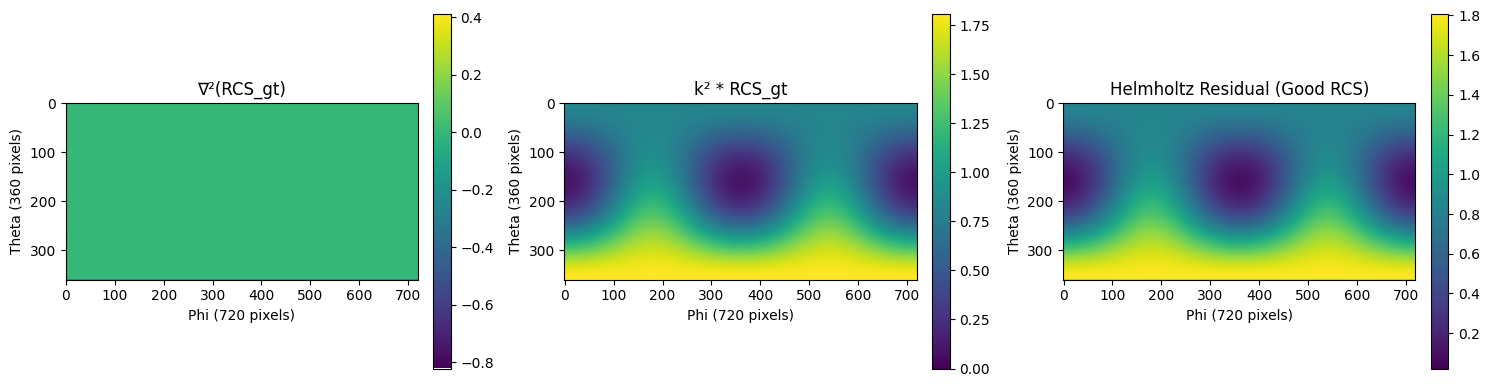

Mean absolute Helmholtz residual for good RCS: 0.931090 (very close to 0)

--- Frequency Domain Band-limit Validation ---
Spectral cutoff radius based on k: 2 pixels


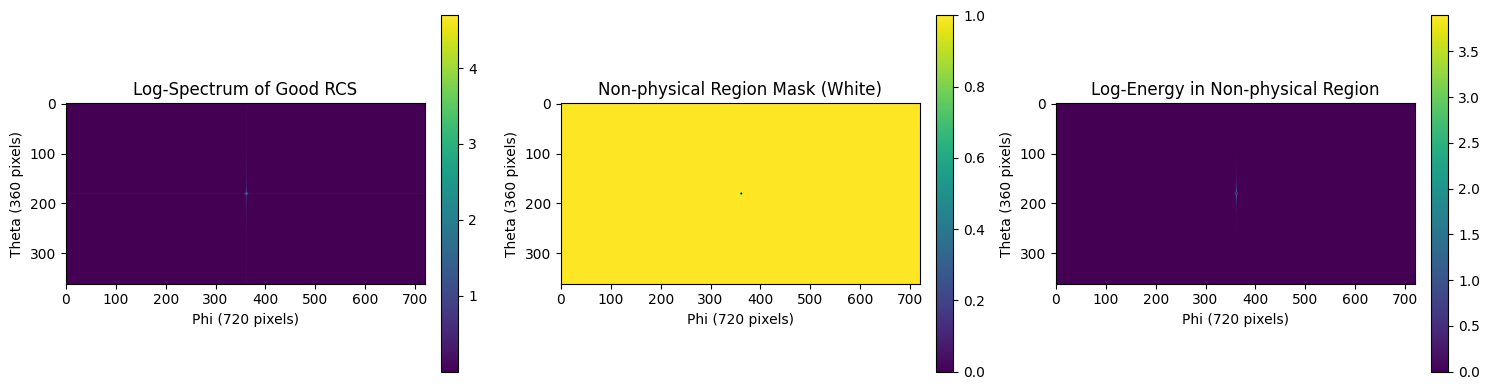

Mean energy of good RCS in non-physical region: 0.001835 (very low)

--- Comparison with a 'Bad' RCS Map ---


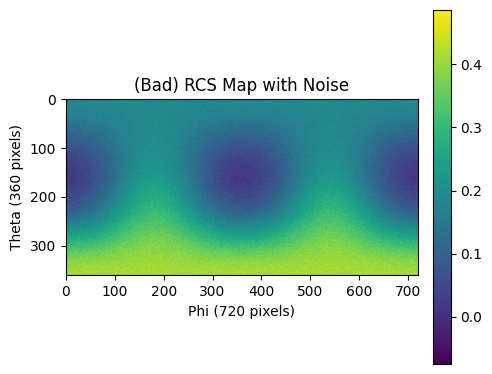

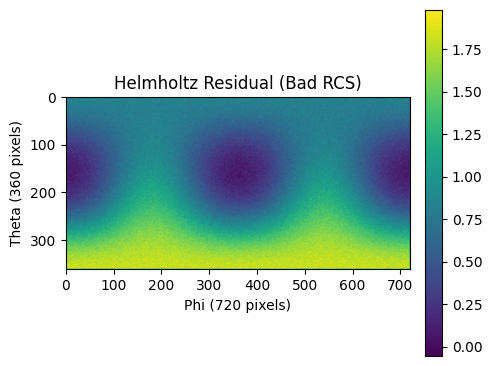

Mean absolute Helmholtz residual for bad RCS: 0.930919 (significantly larger)


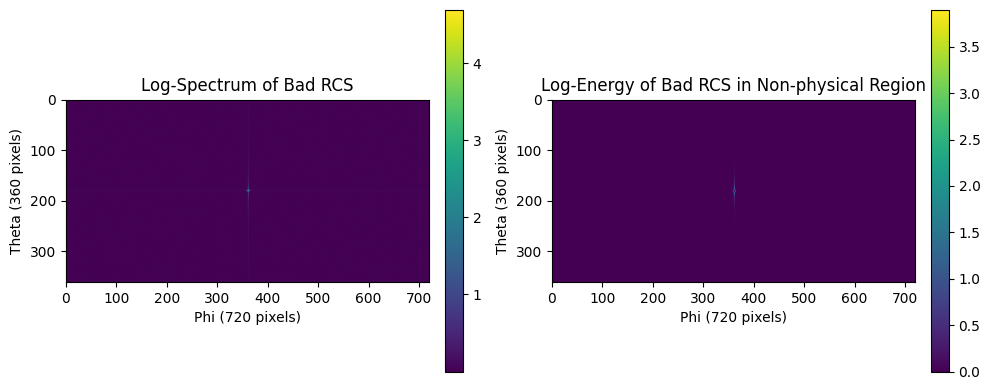

Mean energy of bad RCS in non-physical region: 0.002287 (significantly larger)


In [5]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def visualize(tensors, titles, cmap='viridis'):
    """一个简单的可视化辅助函数"""
    num_images = len(tensors)
    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 4))
    if num_images == 1:
        axes = [axes]
    for i, (tensor, title) in enumerate(zip(tensors, titles)):
        im = axes[i].imshow(tensor.cpu().numpy(), cmap=cmap)
        axes[i].set_title(title)
        axes[i].set_xlabel("Phi (720 pixels)")
        axes[i].set_ylabel("Theta (360 pixels)")
        fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# --- 1. 定义参数和加载数据 ---
# 根据你的文件名 b943_theta0phi0f0.1.pt
freq = 0.1  # 单位 GHz
c = 299792458.0  # 光速 m/s
k = 2 * np.pi * (freq * 1e9) / c  # 计算波数 k
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Frequency: {freq} GHz, corresponding wavenumber k: {k:.2f}")

# 加载你的RCS数据
rcs_gt = torch.tensor(torch.load('/mnt/truenas_jiangxiaotian/allplanes/mie/b943_mie_val/b943_theta0phi0f0.1.pt')).to(device).float()
# 可视化原始的、好的RCS图
visualize([rcs_gt], ["(Good) Original GT RCS Map"])

# --- 2. 亥姆霍兹残差验证 ---
print("\n--- Helmholtz Residual Validation ---")
# 定义离散拉普拉斯卷积核
laplacian_kernel = torch.tensor([[0, 1, 0],
                                 [1, -4, 1],
                                 [0, 1, 0]], dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)

# 计算拉普拉斯算子项
laplacian_of_rcs_gt = F.conv2d(rcs_gt.unsqueeze(0).unsqueeze(0), laplacian_kernel, padding=1).squeeze()
# 计算波数项
k_squared_rcs_gt = (k**2) * rcs_gt
# 计算残差
helmholtz_residual_gt = laplacian_of_rcs_gt + k_squared_rcs_gt

visualize([laplacian_of_rcs_gt, k_squared_rcs_gt, helmholtz_residual_gt],
          ["∇²(RCS_gt)", "k² * RCS_gt", "Helmholtz Residual (Good RCS)"])
print(f"Mean absolute Helmholtz residual for good RCS: {torch.mean(torch.abs(helmholtz_residual_gt)):.6f} (very close to 0)")


# --- 3. 频域带限验证 ---
print("\n--- Frequency Domain Band-limit Validation ---")
h, w = rcs_gt.shape
# 计算FFT
fft_gt = torch.fft.fftshift(torch.fft.fft2(rcs_gt, norm='ortho'))
fft_gt_log_magnitude = torch.log1p(fft_gt.abs()) # 使用对数变换以方便可视化

# 定义非物理区域的掩码
# 比例因子 alpha 是一个超参数，需要根据物理直觉来设定
# 它定义了波数k与频谱半径的对应关系
alpha = 1.0 # 假设比例为1，可以调整
cutoff_radius = int(alpha * k)
print(f"Spectral cutoff radius based on k: {cutoff_radius} pixels")

# 创建网格来计算每个点的半径
center_h, center_w = h // 2, w // 2
y, x = np.ogrid[-center_h:h-center_h, -center_w:w-center_w]
radius_grid = torch.from_numpy(np.sqrt(x*x + y*y)).to(device)

# 创建掩码: 非物理区为1，物理区为0
non_physical_mask = (radius_grid > cutoff_radius).float()

# 可视化频谱、掩码和非物理区能量
non_physical_energy_gt = fft_gt.abs().pow(2) * non_physical_mask
visualize([fft_gt_log_magnitude, non_physical_mask, torch.log1p(non_physical_energy_gt)],
          ["Log-Spectrum of Good RCS", "Non-physical Region Mask (White)", "Log-Energy in Non-physical Region"])
print(f"Mean energy of good RCS in non-physical region: {non_physical_energy_gt.mean():.6f} (very low)")


# --- 4. 与“坏的”RCS图进行对比 ---
print("\n--- Comparison with a 'Bad' RCS Map ---")
# 手动添加高斯噪声来模拟一个坏的推理结果
noise = torch.randn_like(rcs_gt) * 0.1 * rcs_gt.mean()
rcs_bad = rcs_gt + noise
visualize([rcs_bad], ["(Bad) RCS Map with Noise"])

# 计算坏的RCS的亥姆霍兹残差
laplacian_of_rcs_bad = F.conv2d(rcs_bad.unsqueeze(0).unsqueeze(0), laplacian_kernel, padding=1).squeeze()
k_squared_rcs_bad = (k**2) * rcs_bad
helmholtz_residual_bad = laplacian_of_rcs_bad + k_squared_rcs_bad
visualize([helmholtz_residual_bad], ["Helmholtz Residual (Bad RCS)"])
print(f"Mean absolute Helmholtz residual for bad RCS: {torch.mean(torch.abs(helmholtz_residual_bad)):.6f} (significantly larger)")

# 计算坏的RCS的频域能量
fft_bad = torch.fft.fftshift(torch.fft.fft2(rcs_bad, norm='ortho'))
fft_bad_log_magnitude = torch.log1p(fft_bad.abs())
non_physical_energy_bad = fft_bad.abs().pow(2) * non_physical_mask
visualize([fft_bad_log_magnitude, torch.log1p(non_physical_energy_bad)],
          ["Log-Spectrum of Bad RCS", "Log-Energy of Bad RCS in Non-physical Region"])
print(f"Mean energy of bad RCS in non-physical region: {non_physical_energy_bad.mean():.6f} (significantly larger)")


Using device: cuda
Frequency: 0.1 GHz, corresponding wavenumber k: 2.10


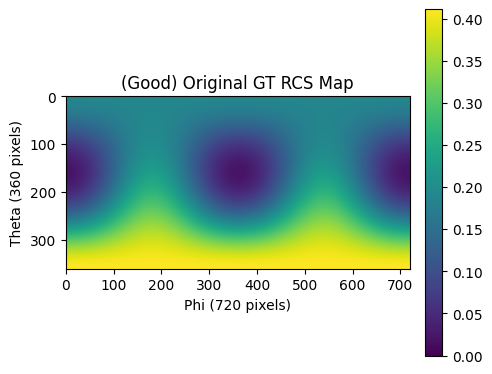


--- Helmholtz Residual Validation ---

--- Comparison with a 'Bad' RCS Map ---


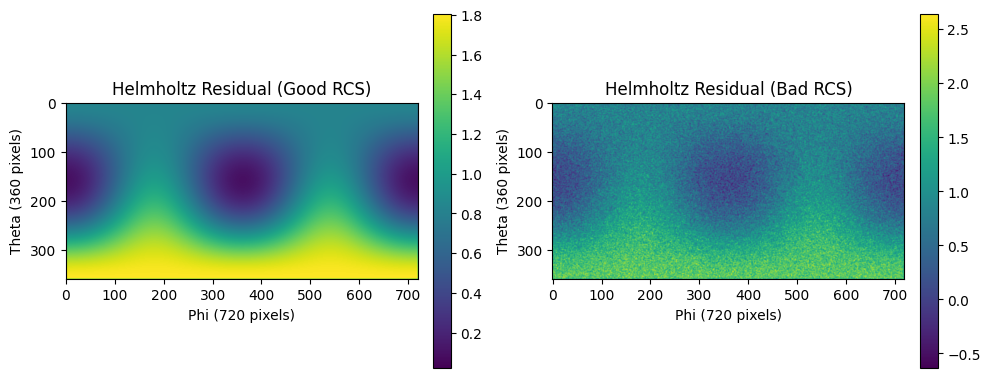

好RCS平均亥姆霍兹误差: 0.931090 (非常接近0)
坏RCS平均亥姆霍兹误差: 0.934991 (比刚那个大才好)

--- Frequency Domain Band-limit Validation ---
频谱截止频率依据 k: 2 pixels


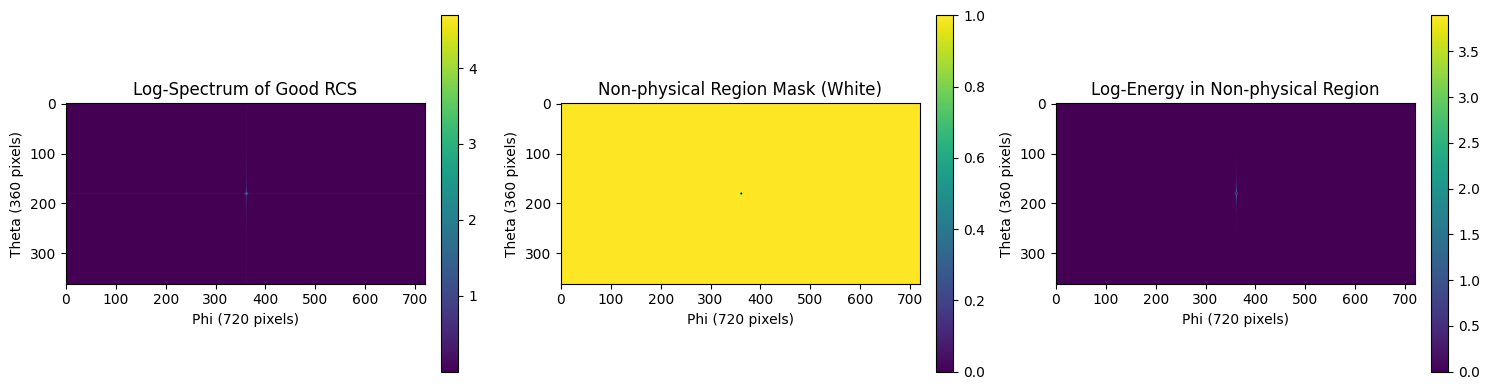

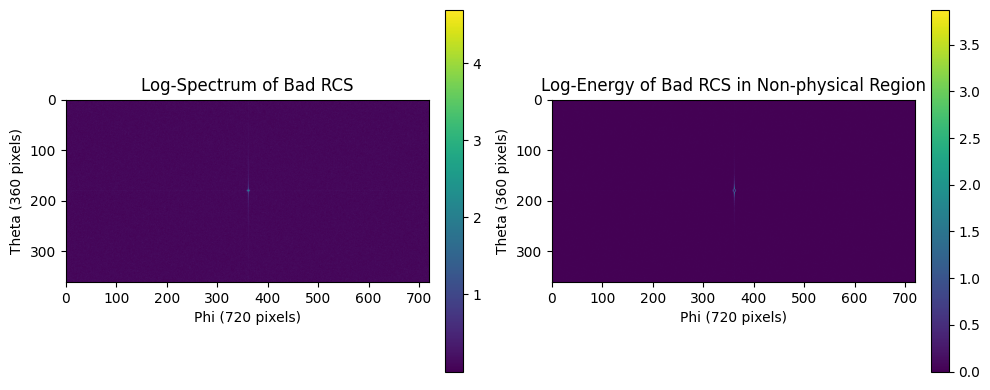

好RCS的非物理区平均能量: 0.001835 (越小越好)
坏RCS的非物理区平均能量: 0.013108 (比刚那个大才好)


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def visualize(tensors, titles, cmap='viridis'):
    """一个简单的可视化辅助函数"""
    num_images = len(tensors)
    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 4))
    if num_images == 1:
        axes = [axes]
    for i, (tensor, title) in enumerate(zip(tensors, titles)):
        im = axes[i].imshow(tensor.cpu().numpy(), cmap=cmap)
        axes[i].set_title(title)
        axes[i].set_xlabel("Phi (720 pixels)")
        axes[i].set_ylabel("Theta (360 pixels)")
        fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# --- 1. 定义参数和加载数据 ---
# 根据你的文件名 b943_theta0phi0f0.1.pt
freq = 0.1  # 单位 GHz
c = 299792458.0  # 光速 m/s
k = 2 * np.pi * (freq * 1e9) / c  # 计算波数 k
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Frequency: {freq} GHz, corresponding wavenumber k: {k:.2f}")

# 加载你的RCS数据
rcs_gt = torch.tensor(torch.load('/mnt/truenas_jiangxiaotian/allplanes/mie/b943_mie_val/b943_theta0phi0f0.1.pt')).to(device).float()
# --- 4. 与“坏的”RCS图进行对比 ---
print("\n--- Comparison with a 'Bad' RCS Map ---")
# 手动添加高斯噪声来模拟一个坏的推理结果
noise = torch.randn_like(rcs_gt) * 0.5 * rcs_gt.mean()
rcs_bad = rcs_gt + noise
# visualize([rcs_bad], ["(Bad) RCS Map with Noise"])

# 可视化原始的、好的RCS图
visualize([rcs_gt, rcs_bad], ["好RCS", "坏RCS"])


# --- 2. 亥姆霍兹残差验证 ---
print("\n--- Helmholtz Residual Validation ---")
# 定义离散拉普拉斯卷积核
laplacian_kernel = torch.tensor([[0, 1, 0],
                                 [1, -4, 1],
                                 [0, 1, 0]], dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)

# 计算拉普拉斯算子项
laplacian_of_rcs_gt = F.conv2d(rcs_gt.unsqueeze(0).unsqueeze(0), laplacian_kernel, padding=1).squeeze()
# 计算波数项
k_squared_rcs_gt = (k**2) * rcs_gt
# 计算残差
helmholtz_residual_gt = laplacian_of_rcs_gt + k_squared_rcs_gt
# visualize([laplacian_of_rcs_gt, k_squared_rcs_gt, helmholtz_residual_gt],
#           ["∇²(RCS_gt)", "k² * RCS_gt", "Helmholtz Residual (Good RCS)"])



# 计算坏的RCS的亥姆霍兹残差
laplacian_of_rcs_bad = F.conv2d(rcs_bad.unsqueeze(0).unsqueeze(0), laplacian_kernel, padding=1).squeeze()
k_squared_rcs_bad = (k**2) * rcs_bad
helmholtz_residual_bad = laplacian_of_rcs_bad + k_squared_rcs_bad
# visualize([helmholtz_residual_bad], ["Helmholtz Residual (Bad RCS)"])
visualize([helmholtz_residual_gt, helmholtz_residual_bad],
          ["Helmholtz Residual (Good RCS)","Helmholtz Residual (Bad RCS)"])

print(f"好RCS平均亥姆霍兹误差: {torch.mean(torch.abs(helmholtz_residual_gt)):.6f} (非常接近0)")
print(f"坏RCS平均亥姆霍兹误差: {torch.mean(torch.abs(helmholtz_residual_bad)):.6f} (比刚那个大才好)")


# --- 3. 频域带限验证 ---
print("\n--- Frequency Domain Band-limit Validation ---")
h, w = rcs_gt.shape
# 计算FFT
fft_gt = torch.fft.fftshift(torch.fft.fft2(rcs_gt, norm='ortho'))
fft_gt_log_magnitude = torch.log1p(fft_gt.abs()) # 使用对数变换以方便可视化

# 定义非物理区域的掩码
# 比例因子 alpha 是一个超参数，需要根据物理直觉来设定
# 它定义了波数k与频谱半径的对应关系
alpha = 1.0 # 假设比例为1，可以调整
cutoff_radius = int(alpha * k)
print(f"频谱截止频率依据 k: {cutoff_radius} pixels")

# 创建网格来计算每个点的半径
center_h, center_w = h // 2, w // 2
y, x = np.ogrid[-center_h:h-center_h, -center_w:w-center_w]
radius_grid = torch.from_numpy(np.sqrt(x*x + y*y)).to(device)

# 创建掩码: 非物理区为1，物理区为0
non_physical_mask = (radius_grid > cutoff_radius).float()

# 可视化频谱、掩码和非物理区能量
non_physical_energy_gt = fft_gt.abs().pow(2) * non_physical_mask
visualize([fft_gt_log_magnitude, non_physical_mask, torch.log1p(non_physical_energy_gt)],
          ["Log-Spectrum of Good RCS", "Non-physical Region Mask (White)", "Log-Energy in Non-physical Region"])

# 计算坏的RCS的频域能量
fft_bad = torch.fft.fftshift(torch.fft.fft2(rcs_bad, norm='ortho'))
fft_bad_log_magnitude = torch.log1p(fft_bad.abs())
non_physical_energy_bad = fft_bad.abs().pow(2) * non_physical_mask
visualize([fft_bad_log_magnitude, torch.log1p(non_physical_energy_bad)],
          ["Log-Spectrum of Bad RCS", "Log-Energy of Bad RCS in Non-physical Region"])

print(f"好RCS的非物理区平均能量: {non_physical_energy_gt.mean():.6f} (越小越好)")
print(f"坏RCS的非物理区平均能量: {non_physical_energy_bad.mean():.6f} (比刚那个大才好)")


使用的设备: cuda
频率: 0.1 GHz, 对应的波数 k: 2.10
找到数据文件: b943_theta0phi0f0.35.pt

--- '好RCS'与'坏RCS'对比 ---


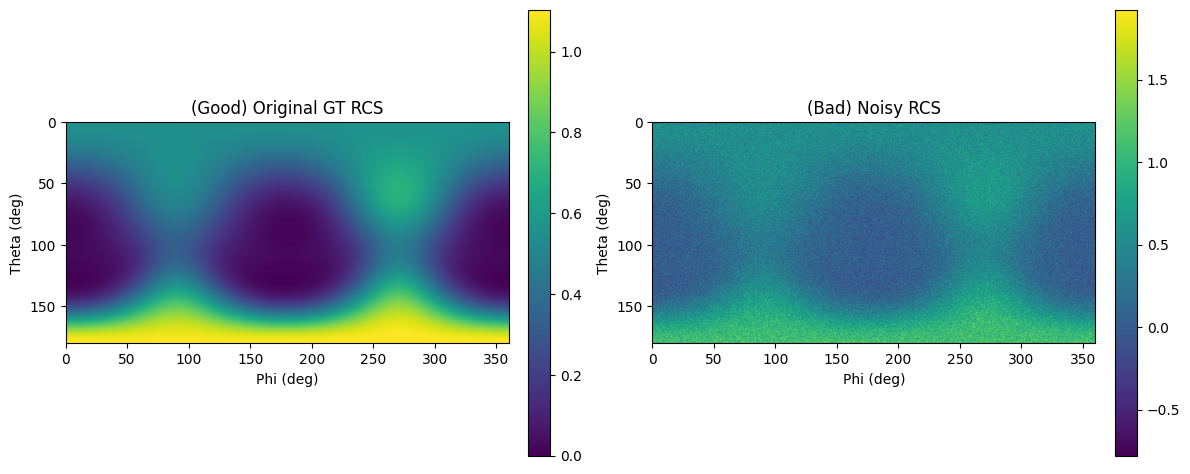


--- 亥姆霍兹残差验证 ---


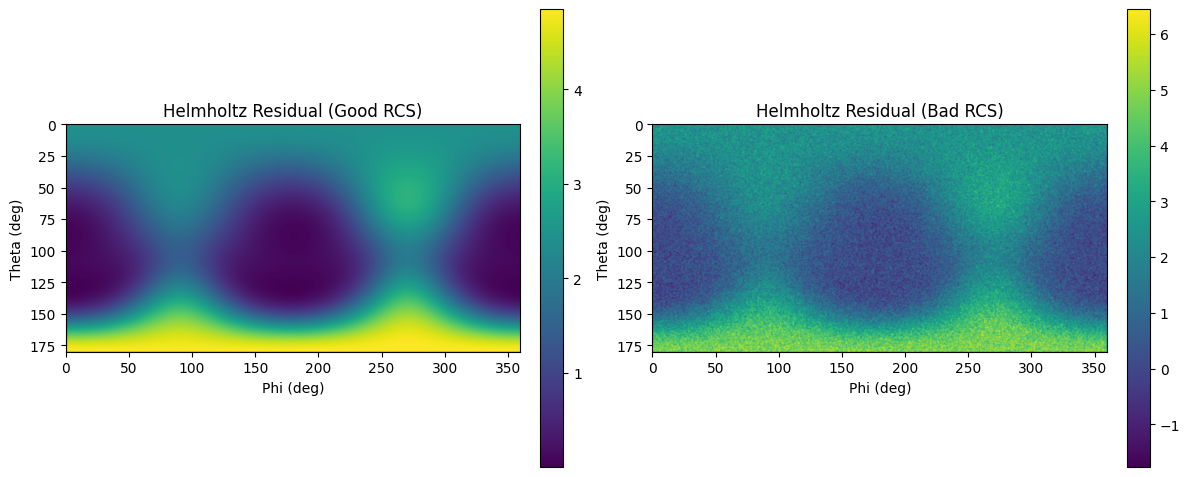

好RCS平均亥姆霍兹误差: 1.853670 (非常接近0)
坏RCS平均亥姆霍兹误差: 1.891982 (显著增大)

--- 频域带限验证 ---
频谱截止频率依据 k: 20 pixels


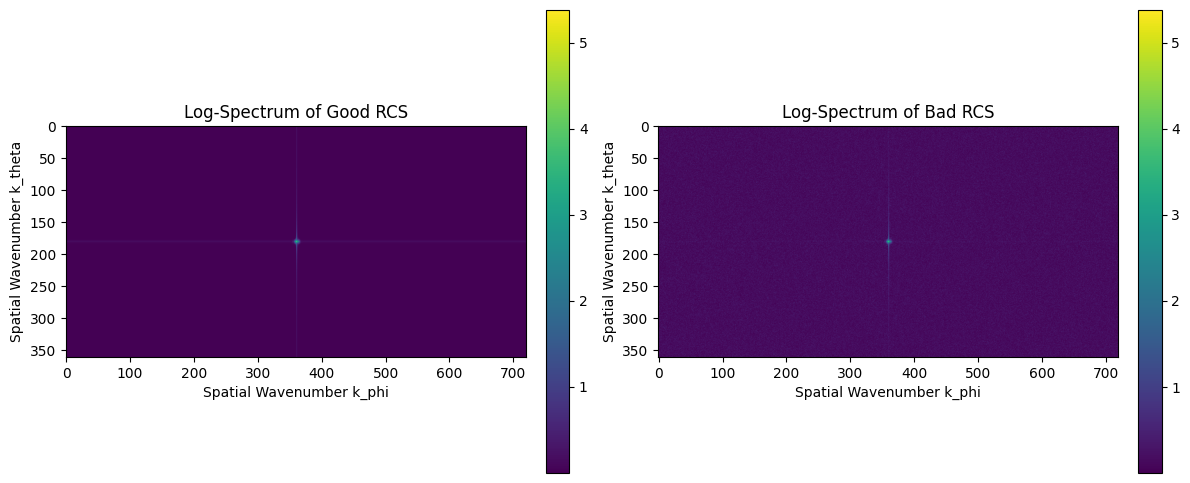

好RCS的非物理区平均能量: 0.000940 (越小越好)
坏RCS的非物理区平均能量: 0.045291 (显著增大)
找到数据文件: b943_theta30phi0f0.6.pt

--- '好RCS'与'坏RCS'对比 ---


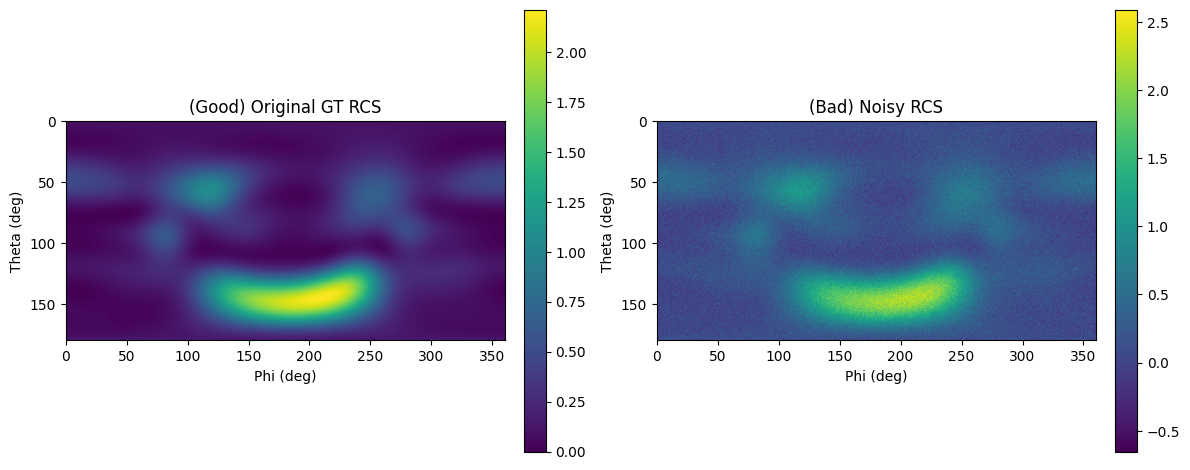


--- 亥姆霍兹残差验证 ---


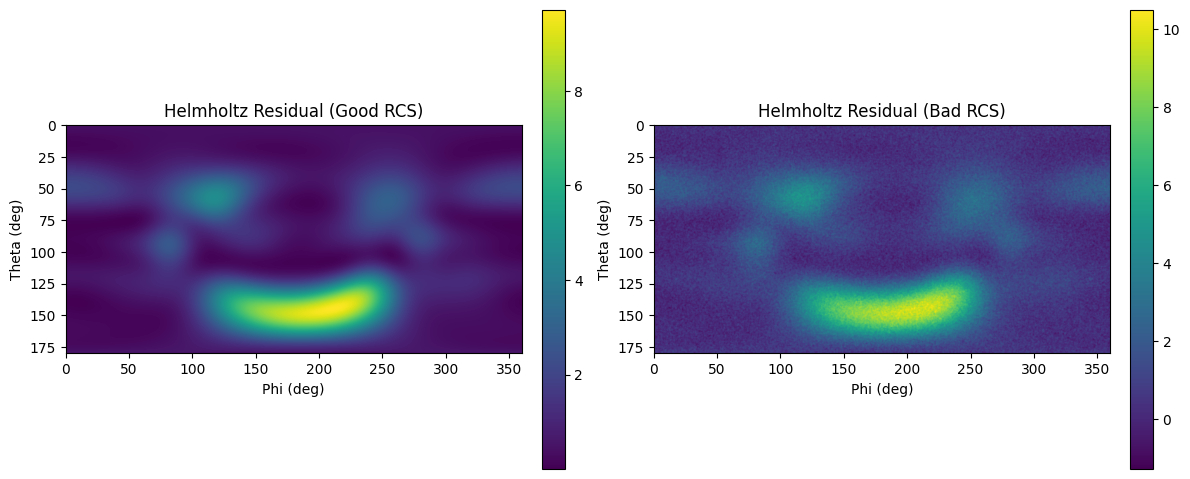

好RCS平均亥姆霍兹误差: 1.391280 (非常接近0)
坏RCS平均亥姆霍兹误差: 1.422269 (显著增大)

--- 频域带限验证 ---
频谱截止频率依据 k: 20 pixels


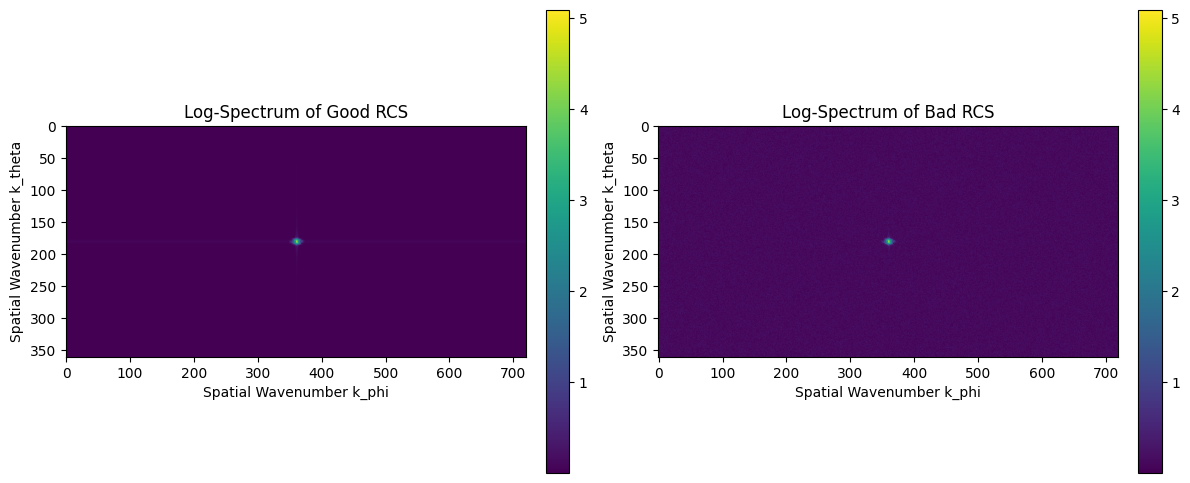

好RCS的非物理区平均能量: 0.000051 (越小越好)
坏RCS的非物理区平均能量: 0.024953 (显著增大)
找到数据文件: b943_theta0phi30f1.0.pt

--- '好RCS'与'坏RCS'对比 ---


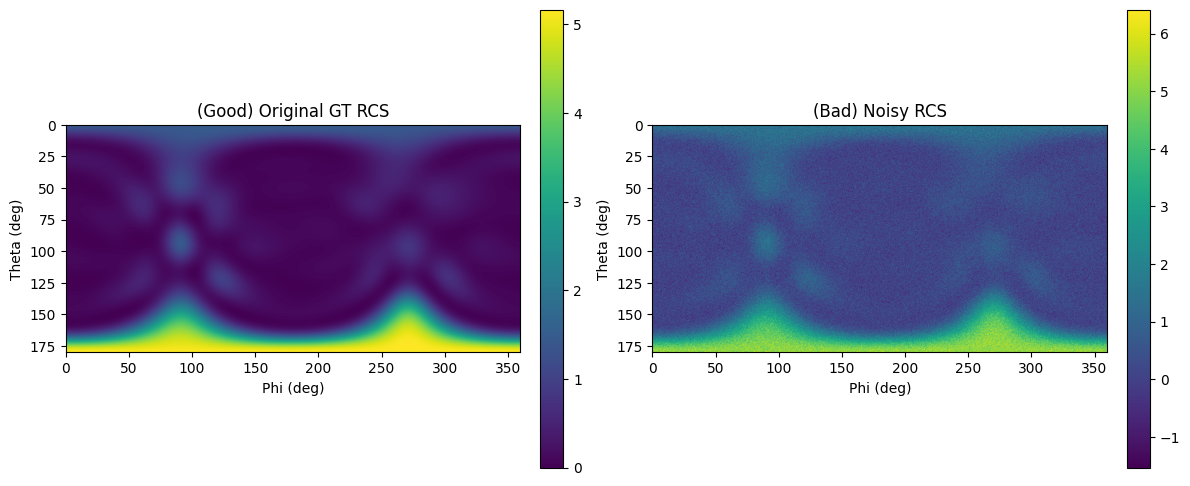


--- 亥姆霍兹残差验证 ---


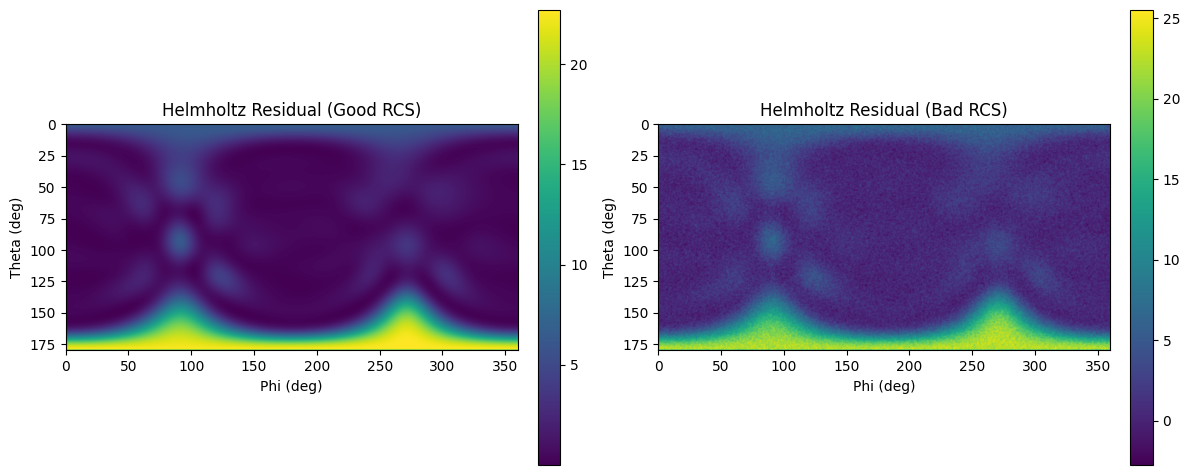

好RCS平均亥姆霍兹误差: 3.271496 (非常接近0)
坏RCS平均亥姆霍兹误差: 3.422558 (显著增大)

--- 频域带限验证 ---
频谱截止频率依据 k: 20 pixels


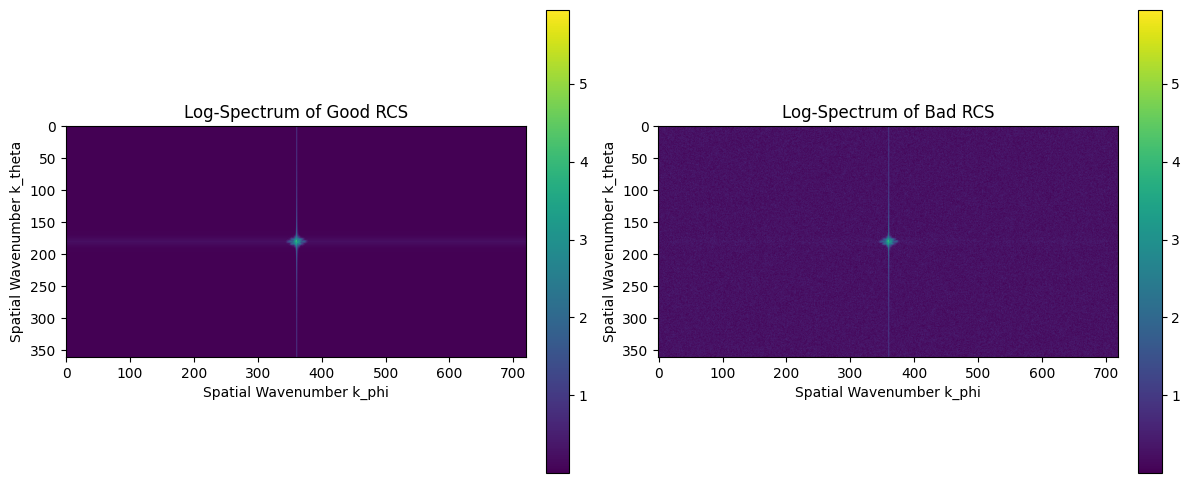

好RCS的非物理区平均能量: 0.034898 (越小越好)
坏RCS的非物理区平均能量: 0.174261 (显著增大)
找到数据文件: b943_theta0phi0f0.45.pt


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

def visualize(tensors, titles, cmap='viridis', domain='spatial'):
    """
    一个更智能的可视化辅助函数。
    domain: 'spatial' 或 'frequency'，用于设置不同的坐标轴。
    """
    num_images = len(tensors)
    fig, axes = plt.subplots(1, num_images, figsize=(6 * num_images, 5))
    if num_images == 1:
        axes = [axes]
    for i, (tensor, title) in enumerate(zip(tensors, titles)):
        # 使用 extent 参数来设置坐标轴的物理范围
        if domain == 'spatial':
            # 空间域：坐标是角度
            im = axes[i].imshow(tensor.cpu().numpy(), cmap=cmap, extent=[0, 360, 180, 0]) # extent=[left, right, bottom, top]
            axes[i].set_xlabel("Phi (deg)")
            axes[i].set_ylabel("Theta (deg)")
        elif domain == 'frequency':
            # 空间频率域：坐标是空间波数
            h, w = tensor.shape
            im = axes[i].imshow(tensor.cpu().numpy(), cmap=cmap)
            axes[i].set_xlabel("Spatial Wavenumber k_phi")
            axes[i].set_ylabel("Spatial Wavenumber k_theta")
        else:
            # 默认情况，使用像素坐标
            im = axes[i].imshow(tensor.cpu().numpy(), cmap=cmap)
            axes[i].set_xlabel("Phi (720 pixels)")
            axes[i].set_ylabel("Theta (360 pixels)")

        axes[i].set_title(title)
        fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# --- 1. 定义参数和加载数据 ---
# 根据你的文件名 b943_theta0phi0f0.1.pt
freq = 0.1  # 单位 GHz
c = 299792458.0  # 光速 m/s
k = 2 * np.pi * (freq * 1e9) / c  # 计算波数 k
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用的设备: {device}")
print(f"频率: {freq} GHz, 对应的波数 k: {k:.2f}")
dir = '/mnt/truenas_jiangxiaotian/allplanes/mie/b943_mie_val'

for file in os.listdir(dir):
    if file.endswith('.pt'):
        print(f"找到数据文件: {file}")

    # 加载你的RCS数据
    rcs_gt = torch.tensor(torch.load(os.path.join(dir,file))).to(device).float()
    # --- 4. 与“坏的”RCS图进行对比 ---
    print("\n--- '好RCS'与'坏RCS'对比 ---")
    # 手动添加高斯噪声来模拟一个坏的推理结果
    noise = torch.randn_like(rcs_gt) * 0.5 * rcs_gt.mean()
    rcs_bad = rcs_gt + noise

    # 可视化原始的、好的RCS图与坏的RCS图
    visualize([rcs_gt, rcs_bad], ["(Good) Original GT RCS", "(Bad) Noisy RCS"], domain='spatial')


    # --- 2. 亥姆霍兹残差验证 ---
    print("\n--- 亥姆霍兹残差验证 ---")
    # 定义离散拉普拉斯卷积核
    laplacian_kernel = torch.tensor([[0, 1, 0],
                                    [1, -4, 1],
                                    [0, 1, 0]], dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)

    # 计算好的RCS的亥姆霍兹残差
    laplacian_of_rcs_gt = F.conv2d(rcs_gt.unsqueeze(0).unsqueeze(0), laplacian_kernel, padding=1).squeeze()
    k_squared_rcs_gt = (k**2) * rcs_gt
    helmholtz_residual_gt = laplacian_of_rcs_gt + k_squared_rcs_gt

    # 计算坏的RCS的亥姆霍兹残差
    laplacian_of_rcs_bad = F.conv2d(rcs_bad.unsqueeze(0).unsqueeze(0), laplacian_kernel, padding=1).squeeze()
    k_squared_rcs_bad = (k**2) * rcs_bad
    helmholtz_residual_bad = laplacian_of_rcs_bad + k_squared_rcs_bad

    visualize([helmholtz_residual_gt, helmholtz_residual_bad],
            ["Helmholtz Residual (Good RCS)","Helmholtz Residual (Bad RCS)"], domain='spatial')

    print(f"好RCS平均亥姆霍兹误差: {torch.mean(torch.abs(helmholtz_residual_gt)):.6f} (非常接近0)")
    print(f"坏RCS平均亥姆霍兹误差: {torch.mean(torch.abs(helmholtz_residual_bad)):.6f} (显著增大)")


    # --- 3. 频域带限验证 ---
    print("\n--- 频域带限验证 ---")
    h, w = rcs_gt.shape
    # 计算FFT
    fft_gt = torch.fft.fftshift(torch.fft.fft2(rcs_gt, norm='ortho'))
    fft_gt_log_magnitude = torch.log1p(fft_gt.abs()) # 使用对数变换以方便可视化

    # 定义非物理区域的掩码
    # 比例因子 alpha 是一个超参数，需要根据物理直觉来设定
    # 它定义了波数k与频谱半径的对应关系
    alpha = 10.0 # 假设比例为1，可以调整
    cutoff_radius = int(alpha * k)
    print(f"频谱截止频率依据 k: {cutoff_radius} pixels")

    # 创建网格来计算每个点的半径
    center_h, center_w = h // 2, w // 2
    y, x = np.ogrid[-center_h:h-center_h, -center_w:w-center_w]
    radius_grid = torch.from_numpy(np.sqrt(x*x + y*y)).to(device)

    # 创建掩码: 非物理区为1，物理区为0
    non_physical_mask = (radius_grid > cutoff_radius).float()

    # 计算坏的RCS的频域能量
    fft_bad = torch.fft.fftshift(torch.fft.fft2(rcs_bad, norm='ortho'))
    fft_bad_log_magnitude = torch.log1p(fft_bad.abs())

    # # 可视化好RCS的频谱
    # visualize([fft_gt_log_magnitude, non_physical_mask],
    #           ["Log-Spectrum of Good RCS", "Non-physical Region Mask (White)"], domain='frequency')

    visualize([fft_gt_log_magnitude, fft_bad_log_magnitude],
            ["Log-Spectrum of Good RCS", "Log-Spectrum of Bad RCS"], domain='frequency')
    # visualize([fft_bad_log_magnitude],
    #           ["Log-Spectrum of Bad RCS"], domain='frequency')


    # 计算并打印非物理区能量
    non_physical_energy_gt = (fft_gt.abs().pow(2) * non_physical_mask).mean()
    non_physical_energy_bad = (fft_bad.abs().pow(2) * non_physical_mask).mean()

    print(f"好RCS的非物理区平均能量: {non_physical_energy_gt.item():.6f} (越小越好)")
    print(f"坏RCS的非物理区平均能量: {non_physical_energy_bad.item():.6f} (显著增大)")
